### Statistical Method (AR & ARIMA)

### From scratch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax as sm

In [4]:
file = "../datasets/clean/df_41017.csv"
df = pd.read_csv(file, index_col=0)
df.index = pd.to_datetime(df.index)

In [5]:
train = df[df.index < pd.to_datetime("2016/01/01")]
test = df[df.index > pd.to_datetime("2016/01/01")]
print(f"Train: {train.shape}\nTest: {test.shape}")

Train: (24121, 1)
Test: (8783, 1)


In [6]:
class AutoRegressive:
    
    def __init__(self, p, df):
        self.p = p
        self.df = df
        
        df_temp = self.df.copy()
        
        for lag in range(1, self.p+1):
            df_temp[f"Shifted_values_{lag}"] = df_temp.swh.shift(lag)

        self.train = df_temp[df_temp.index < pd.to_datetime("2016/01/01")]
        self.test = df_temp[df_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, self.p)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
    
    def predict(self, steps=100):
        self.steps = steps
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = self.X_train.dot(self.theta) + self.intercept
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,self.p)
        
        self.test['Predicted Values'] = self.X_test.dot(self.theta) + self.intercept
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.p} lags.")
        print(f"MAE: {self.MAE} with {self.p} lags")
        
        self.prediction = pd.DataFrame([self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Actual', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.RMSE, self.MAE
    
    
    def get_all_residuals(self):
        train_residuals = pd.DataFrame([self.train['swh'], self.train['Predicted Values'], self.train['swh'].values - self.train['Predicted Values']]).T
        train_residuals.columns = ['Actual', 'Predicted', 'Residuals']
        test_residuals = self.prediction
        test_residuals['Residuals'] = self.prediction['Actual'] - self.prediction['Predicted']
        test_residuals.index = self.test.index[:len(self.prediction)]
        self.residuals = pd.concat([train_residuals, test_residuals])
        
        return self.residuals
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Actual.values, label='Actual')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('Autoregressive')
        plt.legend()
        plt.show()
        
        
    def plot_residuals(self):
        residuals = pd.DataFrame(self.prediction['Actual'] - self.prediction['Predicted'])
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(residuals)
        ax1.set_title("residual line plot")
        ax2 = sns.distplot(residuals)
        ax2.set_title("residual density plot")
        plt.show()
        print("Statistics:")
        print(residuals.describe())

        

class MA:
    
    def __init__(self, q, residuals):
        self.q = q
        self.residuals = residuals
        
        residuals_temp = self.residuals.copy()
                
        for lag in range(1, self.q+1):
            residuals_temp[f"Shifted_values_{lag}"] = residuals_temp.Residuals.shift(lag)

        self.train = residuals_temp[residuals_temp.index < pd.to_datetime("2016/01/01")]
        self.test = residuals_temp[residuals_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, self.q)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
        
    def predict(self, steps=None):
        if steps is None:
            steps = self.test
        try:
            if steps > len(self.test):
                raise ValueError(f'Maximum steps are {len(self.test)}.')
            else:
                self.steps = steps
        except ValueError as error:
            print(f'Value must be integer and the maximum steps are {len(self.test)} steps.')
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = self.X_train.dot(self.theta) + self.intercept
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,self.q)
        
        self.test['Predicted Values'] = self.X_test.dot(self.theta) + self.intercept
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.q} lags.")
        print(f"MAE: {self.MAE} with {self.q} lags.")
        
        self.prediction = pd.DataFrame([self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Residuals', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.RMSE, self.MAE
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Residuals.values, label='Residuals')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('MA')
        plt.legend()
        plt.show()
        

        
class SeasonalAR:
    
    def __init__(self, p, P, df, s, ar_theta):
        if p > 0 or P > 0:
            self.p = p
            self.P = P
        else:
            return "No MA / MA Seasonality"
        self.s = s
        self.df = df
        self.ar_theta = ar_theta
        
        df_temp = self.df.copy()
        
        season_lags = set()
        temp_P = self.P
        for backshift_1 in range(self.s,self.s+self.p+1):
            season_lags.add(backshift_1)
            for backshift_2 in range(self.s*temp_P, self.s*temp_P+self.p+1):
                season_lags.add(backshift_2)
            if temp_P != 1:
                temp_P -= 1
            else:
                break
                
        for lag in list(season_lags):
            df_temp[f"Shifted_values_{lag}"] = df_temp.swh.shift(lag)

        self.train = df_temp[df_temp.index < pd.to_datetime("2016/01/01")]
        self.train = self.train.reindex([self.train.columns[0]] + sorted(self.train.columns[1:]), axis=1)
        self.test = df_temp[df_temp.index > pd.to_datetime("2016/01/01")]
        self.test = self.test.reindex([self.test.columns[0]] + sorted(self.test.columns[1:]), axis=1)
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, len(self.train.columns)-1)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,len(self.test.columns)-1)
             
    def predict(self, steps=100):
        self.steps = steps
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        indexes = [x+1 for x in range(self.p,self.p*self.P+self.p, self.p)]

        X_train_backshift = self.X_train.copy()
        X_test_backshift = self.X_test.copy()

        for index in indexes[:-1]:
            X_train_backshift = np.delete(X_train_backshift,index, 1)
            X_test_backshift = np.delete(X_test_backshift, index, 1)
        
        self.train['Predicted Values'] = self.theta[::self.p+1].T[0].dot(self.X_train[:,::self.p+1].T +
            ((self.ar_theta.repeat(self.X_train[:,1:].shape[1]/len(self.ar_theta),1).T.reshape(-1).dot(X_train_backshift[:,1:].T)).reshape(-1,1).T))
                
        self.test['Predicted Values'] = self.theta[::self.p+1].T[0].dot(self.X_test[:,::self.p+1].T +
            ((self.ar_theta.repeat(self.X_test[:,1:].shape[1]/len(self.ar_theta),1).T.reshape(-1).dot(X_test_backshift[:,1:].T)).reshape(-1,1).T))
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.P} seasonal lags.")
        print(f"MAE: {self.MAE} with {self.P} seasonal lags.")
        
        self.prediction = pd.DataFrame([self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Actual', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.RMSE, self.MAE
    
    
    def get_all_residuals(self):
        train_residuals = pd.DataFrame([self.train['swh'], self.train['Predicted Values'], self.train['swh'].values - self.train['Predicted Values']]).T
        train_residuals.columns = ['Actual', 'Predicted', 'Residuals']
        test_residuals = self.prediction
        test_residuals['Residuals'] = self.prediction['Actual'] - self.prediction['Predicted']
        test_residuals.index = self.test.index[:len(self.prediction)]
        self.residuals = pd.concat([train_residuals, test_residuals])
        
        return self.residuals
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Actual.values, label='Actual')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('Autoregressive Seasonality')
        plt.legend()
        plt.show()
    
    
    def plot_residuals(self):
        residuals = pd.DataFrame(self.prediction['Actual'] - self.prediction['Predicted'])
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(residuals)
        ax1.set_title("residual line plot")
        ax2 = sns.distplot(residuals)
        ax2.set_title("residual density plot")
        plt.show()
        print("Statistics:")
        print(residuals.describe())
        

        
class SeasonalMA:
    
    def __init__(self, q, Q, residuals, s, ma_theta):
        
        if q > 0 or Q > 0:
            self.q = q
            self.Q = Q
        else:
            return "No MA / MA Seasonality"

        self.s = s
        self.residuals = residuals
        self.ma_theta = ma_theta
        
        residuals_temp = residuals.copy()
        
        season_lags = set()
        temp_Q = self.Q
        for backshift_1 in range(self.s,self.s+self.q+1):
            season_lags.add(backshift_1)
            for backshift_2 in range(self.s*temp_Q, self.s*temp_Q+self.q+1):
                season_lags.add(backshift_2)
            if temp_Q != 1:
                temp_Q -= 1
            else:
                break
        
        for lag in list(season_lags):
            residuals_temp[f"Shifted_values_{lag}"] = residuals_temp.Residuals.shift(lag)

        self.train = residuals_temp[residuals_temp.index < pd.to_datetime("2016/01/01")]
        self.test = residuals_temp[residuals_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, len(self.train.columns)-1)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,len(self.test.columns)-1)
        
        
    def predict(self, steps=None):
        if steps is None:
            steps = self.test
        try:
            if steps > len(self.test):
                raise ValueError(f'Maximum steps are {len(self.test)}.')
            else:
                self.steps = steps
        except ValueError as error:
            print(f'Value must be integer and the maximum steps are {len(self.test)} steps.')
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = self.theta[::self.q+1].T[0].dot(self.X_train[:,::self.q+1].T +
            ((self.ma_theta.repeat(self.X_train[:,1:].shape[1]/len(self.ma_theta),1).T.reshape(-1).dot(self.X_train[:,1:].T)).reshape(-1,1).T))
                
        self.test['Predicted Values'] = self.theta[::self.q+1].T[0].dot(self.X_test[:,::self.q+1].T +
            ((self.ma_theta.repeat(self.X_test[:,1:].shape[1]/len(self.ma_theta),1).T.reshape(-1).dot(self.X_test[:,1:].T)).reshape(-1,1).T))
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.Q} seasonal lags.")
        print(f"MAE: {self.MAE} with {self.Q} seasonal lags.")
        
        self.prediction = pd.DataFrame([self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Residuals', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.MAE
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Residuals.values, label='Residuals')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('MA Seasonality')
        plt.legend()
        plt.show()

#### AR

In [7]:
df2 = df.copy()
p, d, q = 3, 0, 2
autoregressive = AutoRegressive(p, df2)
autoregressive_pred = autoregressive.predict()
autoregressive_metrics = autoregressive.get_metrics()

RMSE: 0.1330132353640374 with 3 lags.
MAE: 0.10258493122968082 with 3 lags


In [8]:
autoregressive_pred.head()

,Actual,Predicted
date,,
2016-01-01 00:50:00,2.59,2.561150
2016-01-01 01:50:00,2.71,2.574531
2016-01-01 02:50:00,2.88,2.647679
2016-01-01 03:50:00,2.83,2.763223
2016-01-01 04:50:00,3.11,2.812433


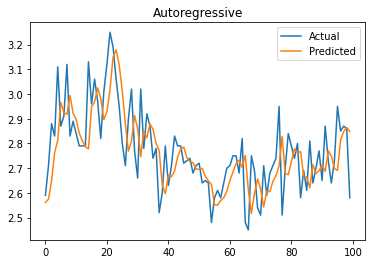

In [9]:
autoregressive.plot_predict()

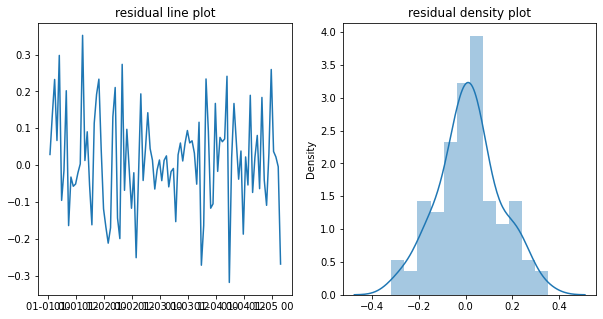

Statistics:
                0
count  100.000000
mean     0.013623
std      0.132980
min     -0.318262
25%     -0.057815
50%      0.013548
75%      0.082987
max      0.351974


In [10]:
autoregressive.plot_residuals()

In [11]:
autoregressive_resid = autoregressive.get_all_residuals()
autoregressive_resid.head()

,Actual,Predicted,Residuals
date,,,
2013-04-01 02:50:00,2.47,2.241565,0.228435
2013-04-01 03:50:00,2.31,2.365509,-0.055509
2013-04-01 04:50:00,2.37,2.357054,0.012946
2013-04-01 05:50:00,2.25,2.362587,-0.112587
2013-04-01 06:50:00,2.25,2.293997,-0.043997


#### MA

In [12]:
ma_model = MA(q, autoregressive_resid[['Residuals']])
ma_pred = ma_model.predict(100)
ma_metrics = ma_model.get_metrics()

RMSE: 0.1326800548990265 with 2 lags.
MAE: 0.10259615732223194 with 2 lags.


In [13]:
ma_pred.head()

,Residuals,Predicted
date,,
2016-01-01 00:50:00,0.028850,0.001596
2016-01-01 01:50:00,0.135469,-0.002616
2016-01-01 02:50:00,0.232321,-0.002024
2016-01-01 03:50:00,0.066777,-0.005368
2016-01-01 04:50:00,0.297567,-0.005824


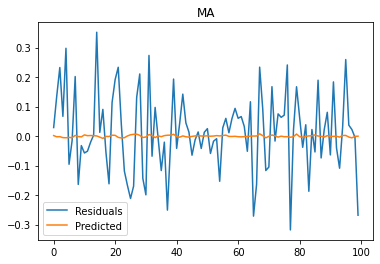

In [14]:
ma_model.plot_predict()

#### ARIMA

In [15]:
ARIMA_pred = autoregressive_pred['Predicted'] + ma_pred['Predicted'].values

In [16]:
ARIMA = pd.DataFrame([autoregressive_pred['Actual'].values,
                      ARIMA_pred,
                      autoregressive_pred['Actual'].values-ARIMA_pred]).T
ARIMA.columns = ['Actual', 'Predicted', 'Residuals']
ARIMA.index = autoregressive_pred.index

In [17]:
ARIMA.head()

,Actual,Predicted,Residuals
date,,,
2016-01-01 00:50:00,2.59,2.562747,0.027253
2016-01-01 01:50:00,2.71,2.571915,0.138085
2016-01-01 02:50:00,2.88,2.645655,0.234345
2016-01-01 03:50:00,2.83,2.757855,0.072145
2016-01-01 04:50:00,3.11,2.806609,0.303391


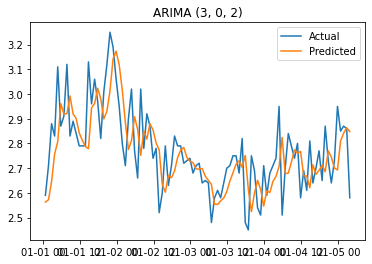

RMSE: 0.13268005489902654
MAE: 0.10259615732223198


In [18]:
plt.plot(ARIMA.Actual, label='Actual')
plt.plot(ARIMA.Predicted, label='Predicted')
plt.title(f'ARIMA ({p}, 0, {q})')
plt.legend()
plt.show()
print(f"RMSE: {np.sqrt(mean_squared_error(ARIMA.Actual, ARIMA.Predicted))}")
print(f"MAE: {mean_absolute_error(ARIMA.Actual, ARIMA.Predicted)}")

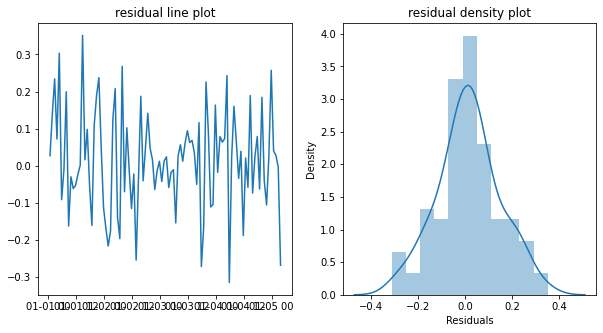

count    100.000000
mean       0.014165
std        0.132586
min       -0.314232
25%       -0.059184
50%        0.016487
75%        0.082086
max        0.351551
Name: Residuals, dtype: float64

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(ARIMA.Residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(ARIMA.Residuals)
ax2.set_title("residual density plot")
plt.show()
ARIMA.Residuals.describe()

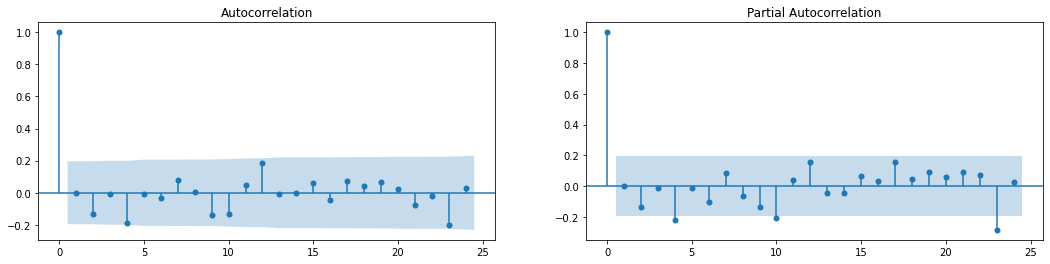

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(ARIMA.Residuals, lags=24, ax=ax1)
ax2 = plot_pacf(ARIMA.Residuals, lags=24, ax=ax2)

#### With seasonality (SARIMAX)

In [21]:
seasonality = pd.DataFrame(seasonal_decompose(df).seasonal)
seasonality.columns = ['swh']

In [22]:
seasonality2 = seasonality.copy()
seasonality2.head()

,swh
date,
2013-03-31 23:50:00,-0.018987
2013-04-01 00:50:00,-0.017050
2013-04-01 01:50:00,-0.019276
2013-04-01 02:50:00,-0.012658
2013-04-01 03:50:00,-0.004338


In [23]:
P, D, Q, s = 2,0,1,24
ar_theta = autoregressive.theta
seasonality_ar = SeasonalAR(p, P, seasonality2, s, ar_theta)

In [24]:
seasonality_ar_pred = seasonality_ar.predict()

RMSE: 0.02772364299766037 with 2 seasonal lags.
MAE: 0.02438939946917358 with 2 seasonal lags.


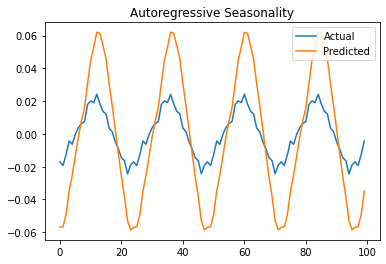

In [25]:
seasonality_ar.plot_predict()

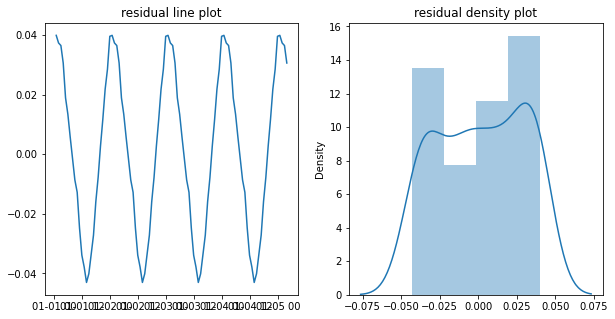

Statistics:
                0
count  100.000000
mean     0.001444
std      0.027826
min     -0.043020
25%     -0.024748
50%      0.002713
75%      0.028550
max      0.039907


In [26]:
seasonality_ar.plot_residuals()

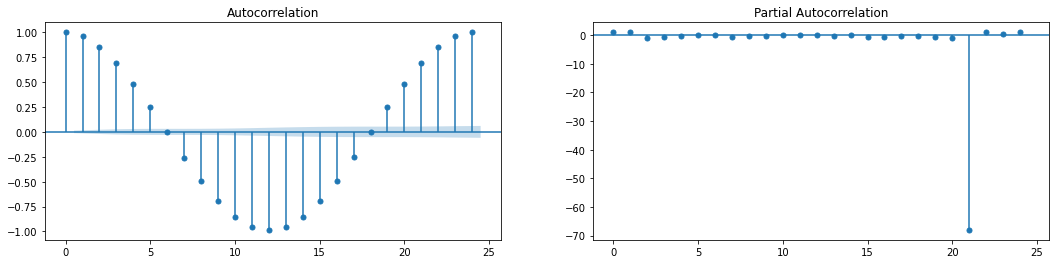

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(seasonality_ar.get_all_residuals().Residuals, lags=24, ax=ax1)
ax2 = plot_pacf(seasonality_ar.get_all_residuals().Residuals, lags=24, ax=ax2)

In [28]:
seasonality_resid = seasonality_ar.get_all_residuals()
seasonality_resid.head()

,Actual,Predicted,Residuals
date,,,
2013-04-03 02:50:00,-0.012658,-0.049147,0.036489
2013-04-03 03:50:00,-0.004338,-0.034959,0.030621
2013-04-03 04:50:00,-0.006332,-0.025268,0.018936
2013-04-03 05:50:00,-0.000293,-0.013703,0.013410
2013-04-03 06:50:00,0.003805,-0.001964,0.005769


In [29]:
ma_theta = ma_model.theta
seasonality_ma = SeasonalMA(q, Q, seasonality_resid[['Residuals']], s, ma_theta)

In [30]:
seasonality_ma_pred = seasonality_ma.predict(100)

RMSE: 0.0008896129026600732 with 1 seasonal lags.
MAE: 0.000785341108507003 with 1 seasonal lags.


In [31]:
seasonality_ma_pred.head()

,Residuals,Predicted
date,,
2016-01-01 00:50:00,0.039907,0.038873
2016-01-01 01:50:00,0.037352,0.036071
2016-01-01 02:50:00,0.036489,0.035226
2016-01-01 03:50:00,0.030621,0.029424
2016-01-01 04:50:00,0.018936,0.017817


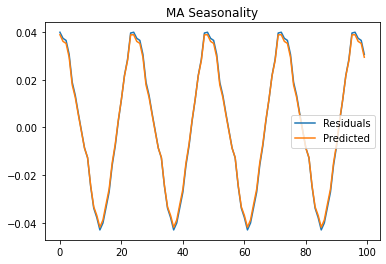

In [32]:
seasonality_ma.plot_predict()

#### Final Results (SARIMA)

In [49]:
seasonality_pred = seasonality_ar_pred['Predicted'] + seasonality_ma_pred['Predicted'].values

In [50]:
SARIMA = pd.DataFrame([ARIMA['Actual'].values,
                        ARIMA.Predicted.values + seasonality_pred.values,
                        ARIMA['Actual'].values-(ARIMA.Predicted.values + seasonality_pred.values)]).T
SARIMA.columns = ['Actual', 'Predicted', 'Residuals']
SARIMA.index = ARIMA.index

In [51]:
SARIMA.head()

,Actual,Predicted,Residuals
date,,,
2016-01-01 00:50:00,2.59,2.544663,0.045337
2016-01-01 01:50:00,2.71,2.551358,0.158642
2016-01-01 02:50:00,2.88,2.631734,0.248266
2016-01-01 03:50:00,2.83,2.752320,0.077680
2016-01-01 04:50:00,3.11,2.799159,0.310841


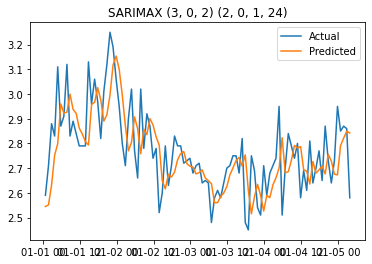

RMSE: 0.1344349900839136
MAE: 0.10476021240964634


In [52]:
plt.plot(SARIMA.Actual, label='Actual')
plt.plot(SARIMA.Predicted, label='Predicted')
plt.title(f'SARIMAX ({p}, {d}, {q}) ({P}, {D}, {Q}, {s})')
plt.legend()
plt.show()
print(f"RMSE: {np.sqrt(mean_squared_error(SARIMA.Actual, SARIMA.Predicted))}")
print(f"MAE: {mean_absolute_error(SARIMA.Actual, SARIMA.Predicted)}")

### Using modules

In [990]:
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm # auto arima
# from sklearn.model_selection import TimeSeriesSplit

#### Autoregressive

In [991]:
def AutoRegressiveModel(train_data, test_data, lags, steps):
    """
    Autoregression using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()
    residuals = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = AutoReg(history, lags=lags).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    return predictions, metrics

In [992]:
ar_predictions, ar_metrics = AutoRegressiveModel(train.swh.values, test.swh.values, 2, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.43it/s]


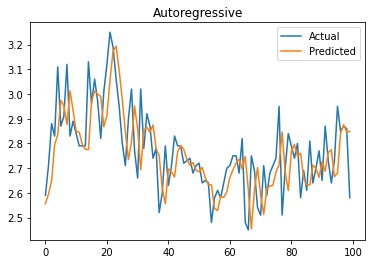

RMSE of AR: 0.1379045749967391
MAE of AR: 0.10378789037768532


In [993]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(ar_predictions, label="Predicted")
plt.title('Autoregressive')
plt.legend()
plt.show()
print(f"RMSE of AR: {ar_metrics[0]}")
print(f"MAE of AR: {ar_metrics[1]}")

#### ARIMA

In [995]:
def ArimaModel(train_data, test_data, arima_order: tuple, steps):
    """
    Arima using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = ARIMA(history, order=arima_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    
    return predictions, metrics

In [1]:
pdq = (3, 0, 2)
arima_predictions, arima_metrics = ArimaModel(train.swh.values, test.swh.values, pdq, 100)

In [ ]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(arima_predictions, label="Predicted")
plt.title(f'ARIMA {pdq}')
plt.legend()
plt.show()
print(f"RMSE of ARIMA: {arima_metrics[0]}")
print(f"MAE of ARIMA: {arima_metrics[1]}")

In [ ]:
residuals = pd.DataFrame(test.swh.values[:100] - arima_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(residuals, lags=24, ax=ax1)
ax2 = plot_pacf(residuals, lags=24, ax=ax2)

#### Arima Model 2 (include predicted data to forecast)

In [274]:
def ArimaModel2(train_data, test_data, arima_order: tuple, steps):
    """
    Arima using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = ARIMA(history, order=arima_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(yhat)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    
    return predictions, metrics

In [275]:
pdq = (2,0,2)
arima_predictions, arima_metrics = ArimaModel2(train.swh.values, test.swh.values, pdq, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:10<00:00, 12.10s/it]


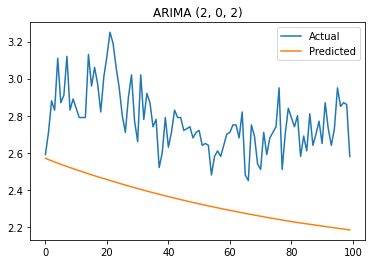

RMSE of ARIMA: 0.45473535211658705
MAE of ARIMA: 0.43047112040366514


In [276]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(arima_predictions, label="Predicted")
plt.title(f'ARIMA {pdq}')
plt.legend()
plt.show()
print(f"RMSE of ARIMA: {arima_metrics[0]}")
print(f"MAE of ARIMA: {arima_metrics[1]}")

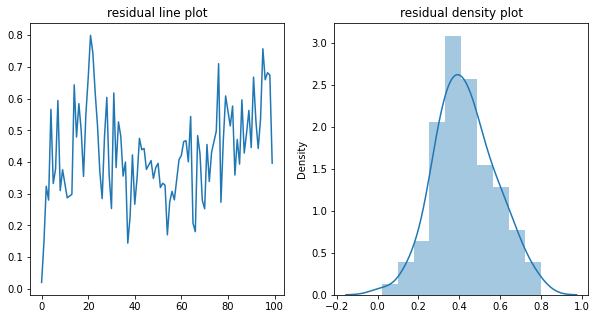

,0
count,100.000000
mean,0.430471
std,0.147295
min,0.019996
25%,0.332006
50%,0.421679
75%,0.527659
max,0.799719


In [277]:
residuals = pd.DataFrame(test.swh.values[:100] - arima_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

#### SARIMAX

In [273]:
def SarimaxModel(train_data, test_data, arima_order, seasonal_order, steps):
    history = [x for x in train_data]
    predictions = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = sm.SARIMAX(history, order=arima_order, seasonal_order=seasonal_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    
    return predictions, metrics

In [141]:
PDQs = (1,0,1,24)
sarimax_predictions, sarimax_metrics = SarimaxModel(train.swh.values, test.swh.values, pdq, PDQs, 100)

In [ ]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(sarimax_predictions, label="Predicted")
plt.title(f'SARIMAX {pqd}{PDQs}')
plt.legend()
plt.show()
print(f"RMSE of ARIMA: {sarimax_metrics[0]}")
print(f"MAE of ARIMA: {sarimax_metrics[1]}")

In [ ]:
sarimax_residuals = pd.DataFrame(test.swh.values[:100] - sarimax_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(sarimax_residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(sarimax_residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(sarimax_residuals, lags=24, ax=ax1)
ax2 = plot_pacf(sarimax_residuals, lags=24, ax=ax2)

Search for the best fit parameter

In [17]:
# def GridArimaModel(train_data, test_data, p_values: list, d_values: list, q_values: list, steps):
#     """
#     Best fit Arima using walk forward validation
#     """
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     _, metrics = ArimaModel(train_data, test_data, (p,d,q), steps)
#                     if metrics[0] < best_score:
#                         best_score, best_cfg = metrics, order
#                 except:
#                     continue

#     predictions, metrics = ArimaModel(train_data, test_data, best_cfg, steps)

#     return predictions, best_cfg, best_score

In [22]:
# best_prediction, best_cfg, best_score = GridArimaModel(train.swh.values, test.swh.values,list(range(1,3)), [0], [1], 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]


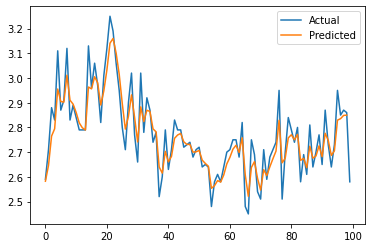

Best parameter of order: (1, 0, 1)
MSE of ARIMA: 0.0038912259457331453


In [23]:
# plt.plot(test.swh.values[:100], label="Actual")
# plt.plot(best_prediction, label="Predicted")
# plt.legend()
# plt.show()
# print(f"Best parameter of order: {best_cfg}")
# print(f"RMSE of ARIMA: {best_score[0]}")
# print(f"MAE of ARIMA: {best_score[1]}")

----